# Membership Inference over Diffusion-models-based Synthetic Tabular Data (MIDST) Challenge @ SaTML 2025.

This notebook will walk you through the process of how we achieve a good score in **Black Box Single Table Competition**.

We only work on **TabDDPM** in this task.

This competition focuses on Black Box MIA on tabular diffusion models trained on a single table transaction dataset. The schema of the transaction dataset is as follows:
| trans_id | account_id | trans_date | trans_type | operation | amount  | balance  | k_symbol | bank | account |
|----------|------------|------------|------------|-----------|---------|----------|----------|------|---------|
| integer  | integer    | integer    | integer    | integer   | float   | float    | integer  | integer | integer |


**Package Imports and Evironment Setup**

Ensure that you have installed the proper dependenices to run the notebook. The environment installation instructions are available [here](https://github.com/VectorInstitute/MIDSTModels/tree/main/starter_kits). Now that we have verfied we have the proper packages installed, lets import them and define global variables:

## 1. Model preparation

In black box single table competition, we only have 20k synthetic data to support our membership inferences.

In order to gain more information from the hidden diffusion model, we train a shadow model, with the 20k synthethic data, using the same provided configuration file "../midst_models/single_table_TabDDPM/configs/trans_demo.json"

Please refer to "train_single_table_DM.py" to train the shadow model for each folder in train (30), dev (20), and final (20).

**You should do this step first to get the shadow model!!!!!**

## 2. Loss function

In this part, we define the loss function used in our pipeline. The loss function should maximize the loss difference between training and hold-out samples. As the model may remember training data better, so they should have lower loss between predicted loss and real loss for train data. In this process, we fix the noises to control variables.

Note: We will only list the loss function used finally in this notebook.

In [1]:
import csv
import os
import random
import zipfile

from pathlib import Path
from functools import partial
from typing import Callable, Any

import numpy as np
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points, get_training_points
from metrics import get_tpr_at_fpr

TABDDPM_DATA_DIR = "tabddpm_black_box"
TABSYN_DATA_DIR = "tabsyn_black_box"

In [2]:
# we define the loss function here
# global variables are assigned in the main process
def mixed_loss(diffusion, x, out_dict, noise=None, t=None, pt=None, return_random=False, no_mean=False):
    global t_value
    global input_noise
    global parallel_batch

    x_num = x[:, : diffusion.num_numerical_features]
    x_cat = x[:, diffusion.num_numerical_features :]
    if x_num.shape[1] > 0:
        if noise is None:
            noise = torch.randn_like(x_num)

    noise = input_noise
    noise_tensor = torch.tensor(noise, device='cuda', dtype=torch.float)
    batch_noise = noise_tensor.repeat(x_num.shape[0], 1) 

    # there is actually no categorical classes, as we have examined the DM, so we just ignore x_cat here and later
    x_num = x_num.repeat_interleave(parallel_batch, dim=0)
    x_cat = x_cat.repeat_interleave(parallel_batch, dim=0)

    b = x_num.shape[0]

    log_x_cat_t = x_cat

    device = x.device
    if t is None:
        t, pt = diffusion.sample_time(b, device, "uniform")
    
    if return_random:
        return noise, t, pt 

    global addt_value
    additional_t = t*0 + addt_value

    # forward x_num_t with (t+additional_t) timestamps
    x_num_t = diffusion.gaussian_q_sample(x_num, t+additional_t, noise=batch_noise)
    
    if not return_random:
        current_t = t
        # predict noises with t timestamps
        predicted_noise = diffusion._denoise_fn(x_num_t, current_t, **out_dict)
        current_loss = diffusion._gaussian_loss(predicted_noise, batch_noise, batch_noise, current_t, batch_noise)
        transformed_current_loss = current_loss.reshape(-1, parallel_batch)

    return transformed_current_loss*0, transformed_current_loss

## 3. Loss Processing and Membership Inference

Since raw loss values vary due to noise and different timesteps t_value and add, a simple threshold-based approach is insufficient for robust inference. To address this challenge, we propose a machine-learning-driven approach. Specifically, we introduce a three-layer Multi-Layer Perceptron (MLP) to model the relationship between loss values and membership status, improving attack accuracy.

### 3.1 Data Processing

This part include all the source code used during preprocessing and dataset loading. We use these to preprocess the data to fit into diffusion models. Most of these functions are from TabDDPM with minor modifications.

In [3]:
import numpy as np
import hashlib
import json
import pickle

import os
from typing import Any, Dict, List, Literal, Optional, Tuple, Union, cast
from pathlib import Path
from dataclasses import astuple, dataclass, replace
from midst_models.single_table_TabDDPM.lib import (
    Transformations,
    prepare_fast_dataloader,
    round_columns,
)
from midst_models.single_table_TabDDPM.lib import Dataset, TaskType, transform_dataset

from midst_models.single_table_TabDDPM.complex_pipeline import (
    clava_clustering,
    clava_clustering_force_load,
    clava_load_pretrained_customized,
    load_configs,
)
from midst_models.single_table_TabDDPM.pipeline_utils import load_multi_table_customized

from midst_models.single_table_TabDDPM.complex_pipeline import CustomUnpickler


CAT_MISSING_VALUE = "__nan__"
CAT_RARE_VALUE = "__rare__"
Normalization = Literal["standard", "quantile", "minmax"]
NumNanPolicy = Literal["drop-rows", "mean"]
CatNanPolicy = Literal["most_frequent"]
CatEncoding = Literal["one-hot", "counter"]
YPolicy = Literal["default"]
ArrayDict = Dict[str, np.ndarray]

def raise_unknown(unknown_what: str, unknown_value: Any):
    raise ValueError(f"Unknown {unknown_what}: {unknown_value}")


def get_table_info(df, domain_dict, y_col):
    cat_cols = []
    num_cols = []
    for col in df.columns:
        if col in domain_dict and col != y_col:
            if domain_dict[col]["type"] == "discrete":
                cat_cols.append(col)
            else:
                num_cols.append(col)

    df_info = {}
    df_info["cat_cols"] = cat_cols
    df_info["num_cols"] = num_cols
    df_info["y_col"] = y_col
    df_info["n_classes"] = 0
    df_info["task_type"] = "multiclass"

    return df_info

def get_T_dict():
    return {
        "seed": 0,
        "normalization": "quantile",
        "num_nan_policy": None,
        "cat_nan_policy": None,
        "cat_min_frequency": None,
        "cat_encoding": None,
        "y_policy": "default",
    }

def get_model_params(rtdl_params=None):
    return {
        "num_classes": 0,
        "is_y_cond": "none",
        "rtdl_params": {"d_layers": [512, 1024, 1024, 1024, 1024, 512], "dropout": 0.0}
        if rtdl_params is None
        else rtdl_params,
    }

def build_target(
    y: ArrayDict, policy: Optional[YPolicy], task_type: TaskType
) -> Tuple[ArrayDict, Dict[str, Any]]:
    info: Dict[str, Any] = {"policy": policy}
    if policy is None:
        pass
    elif policy == "default":
        if task_type == TaskType.REGRESSION:
            mean, std = float(y["train"].mean()), float(y["train"].std())
            y = {k: (v - mean) / std for k, v in y.items()}
            info["mean"] = mean
            info["std"] = std
    else:
        raise_unknown("policy", policy)
    return y, info

@dataclass(frozen=True)
class Transformations:
    seed: int = 0
    normalization: Optional[Normalization] = None
    num_nan_policy: Optional[NumNanPolicy] = None
    cat_nan_policy: Optional[CatNanPolicy] = None
    cat_min_frequency: Optional[float] = None
    cat_encoding: Optional[CatEncoding] = None
    y_policy: Optional[YPolicy] = "default"


def transform_dataset(
    dataset: Dataset,
    transformations: Transformations,
    cache_dir: Optional[Path],
    transform_cols_num: int = 0,
    normalizer=None,
    cat_transform=None, 
    num_transform=None
) -> Dataset:
    # WARNING: the order of transformations matters. Moreover, the current
    # implementation is not ideal in that sense.
    if cache_dir is not None:
        transformations_md5 = hashlib.md5(
            str(transformations).encode("utf-8")
        ).hexdigest()
        transformations_str = "__".join(map(str, astuple(transformations)))
        cache_path = (
            cache_dir / f"cache__{transformations_str}__{transformations_md5}.pickle"
        )
        if cache_path.exists():
            cache_transformations, value = util.load_pickle(cache_path)
            if transformations == cache_transformations:
                # print(
                #     f"Using cached features: {cache_dir.name + '/' + cache_path.name}"
                # )
                return value
            else:
                raise RuntimeError(f"Hash collision for {cache_path}")
    else:
        cache_path = None


    cat_transform = None
    X_num = dataset.X_num
    X_num = {k: num_transform.transform(v) for k, v in X_num.items()}

    if dataset.X_cat is None:
        assert transformations.cat_nan_policy is None
        assert transformations.cat_min_frequency is None
        # assert transformations.cat_encoding is None
        X_cat = None
    else:
        X_cat = cat_process_nans(dataset.X_cat, transformations.cat_nan_policy)
        if transformations.cat_min_frequency is not None:
            X_cat = cat_drop_rare(X_cat, transformations.cat_min_frequency)
        
        if cat_transform is None:
            raise ValueError("See why no cat_tramsform")
        else:
            X_cat = {k: cat_transform.transform(v).astype("float32") for k, v in X_cat.items()} 
            X_num = (
                X_cat
                if X_num is None
                else {x: np.hstack([X_num[x], X_cat[x]]) for x in X_num}
            )
            X_cat = None

    y, y_info = build_target(dataset.y, transformations.y_policy, dataset.task_type)

    dataset = replace(dataset, X_num=X_num, X_cat=X_cat, y=y, y_info=y_info)
    dataset.num_transform = num_transform
    dataset.cat_transform = cat_transform

    return dataset

def make_dataset_from_df_with_loaded(df, T, is_y_cond, ratios=[0.7, 0.2, 0.1], df_info=None, std=0, label_encoders=None, num_transform=None):

    cat_column_orders = []
    num_column_orders = []
    index_to_column = list(df.columns)
    column_to_index = {col: i for i, col in enumerate(index_to_column)}

    if df_info["n_classes"] > 0:
        X_cat = {} if df_info["cat_cols"] is not None or is_y_cond == "concat" else None
        X_num = {} if df_info["num_cols"] is not None else None
        y = {}

        cat_cols_with_y = []
        if df_info["cat_cols"] is not None:
            cat_cols_with_y += df_info["cat_cols"]
        if is_y_cond == "concat":
            cat_cols_with_y = [df_info["y_col"]] + cat_cols_with_y

        if len(cat_cols_with_y) > 0:
            X_cat["train"] = df[cat_cols_with_y].to_numpy(dtype=np.str_)

        y["train"] = df[df_info["y_col"]].values.astype(np.float32)

        if df_info["num_cols"] is not None:
            X_num["train"] = df[df_info["num_cols"]].values.astype(np.float32)

        cat_column_orders = [column_to_index[col] for col in cat_cols_with_y]
        num_column_orders = [column_to_index[col] for col in df_info["num_cols"]]

    else:
        X_cat = {} if df_info["cat_cols"] is not None else None
        X_num = {} if df_info["num_cols"] is not None or is_y_cond == "concat" else None
        y = {}

        num_cols_with_y = []
        if df_info["num_cols"] is not None:
            num_cols_with_y += df_info["num_cols"]
        if is_y_cond == "concat":
            num_cols_with_y = [df_info["y_col"]] + num_cols_with_y

        if len(num_cols_with_y) > 0:
            X_num["train"] = df[num_cols_with_y].values.astype(np.float32)

        y["train"] = df[df_info["y_col"]].values.astype(np.float32)

        if df_info["cat_cols"] is not None:
            X_cat["train"] = df[df_info["cat_cols"]].to_numpy(dtype=np.str_)

        cat_column_orders = [column_to_index[col] for col in df_info["cat_cols"]]
        num_column_orders = [column_to_index[col] for col in num_cols_with_y]

    column_orders = num_column_orders + cat_column_orders
    column_orders = [index_to_column[index] for index in column_orders]

    if X_cat is not None and len(df_info["cat_cols"]) > 0:
        X_cat_all = X_cat["train"]
        X_cat_converted = []
        for col_index in range(X_cat_all.shape[1]):
            if label_encoders is None:
                raise ValueError('Should be loaded: label_encoder')
            else:
                pass
                # print('label_encoders loaded')

            X_cat_converted.append(
                label_encoders[col_index].transform(X_cat_all[:, col_index]).astype(float)
            )
            
            if std > 0:
                # add noise
                X_cat_converted[-1] += np.random.normal(
                    0, std, X_cat_converted[-1].shape
                )

        X_cat_converted = np.vstack(X_cat_converted).T

        train_num = X_cat["train"].shape[0]

        X_cat["train"] = X_cat_converted[:train_num, :]

        if len(X_num) > 0:
            X_num["train"] = np.concatenate((X_num["train"], X_cat["train"]), axis=1)
        else:
            X_num = X_cat
            X_cat = None

    D = Dataset(
        X_num,
        None,
        y,
        y_info={},
        task_type=TaskType(df_info["task_type"]),
        n_classes=df_info["n_classes"],
    )

    return transform_dataset(D, T, None, num_transform=num_transform), label_encoders, column_orders


def get_dataset(data_path, config_path =None, save_dir_tmp=None, train_name="train_with_id.csv", phase=None):
    configs, save_dir = load_configs(config_path)
    tables, relation_order, dataset_meta = load_multi_table_customized(data_path, meta_dir="../midst_models/single_table_TabDDPM/configs", train_name=train_name)
    tables, all_group_lengths_prob_dicts = clava_clustering_force_load(
        tables, relation_order, save_dir, configs
    )
    global batch_size
    train_loader_list = []
    for parent, child in relation_order:
        # print(f"Getting {parent} -> {child} model from scratch")
        df_with_cluster = tables[child]["df"]

        id_cols = [col for col in df_with_cluster.columns if "_id" in col]
        df_without_id = df_with_cluster.drop(columns=id_cols)

        child_df_with_cluster, child_domain_dict, parent_name, child_name =  df_without_id, tables[child]["domain"], parent, child
        if parent_name is None:
            y_col = "placeholder"
            child_df_with_cluster["placeholder"] = list(range(len(child_df_with_cluster)))
        else:
            y_col = f"{parent_name}_{child_name}_cluster"
        child_info = get_table_info(child_df_with_cluster, child_domain_dict, y_col)
        child_model_params = get_model_params(
            {
                "d_layers": configs["diffusion"]["d_layers"],
                "dropout": configs["diffusion"]["dropout"],
            }
        )
        child_T_dict = get_T_dict()
        file_path = os.path.join(save_dir_tmp, f"{parent}_{child}_ckpt.pkl")
        with open(file_path, "rb") as f:
            model = CustomUnpickler(f).load()

        diffusion = model['diffusion'].cuda()
        num_transform = model['dataset'].num_transform
        T = Transformations(**child_T_dict)

        dataset, label_encoders, column_orders = make_dataset_from_df_with_loaded(
            child_df_with_cluster,
            T,
            is_y_cond=child_model_params["is_y_cond"],
            ratios=[0.99, 0.005, 0.005],
            df_info=child_info,
            std=0,
            label_encoders=model['label_encoders'],
            num_transform=num_transform
        )

        dataset.X_num['test'] = dataset.X_num['train']

        if dataset.X_cat is not None:
            dataset.X_cat['test'] = dataset.X_cat['train']
        dataset.y['test'] = dataset.y['train']
        train_loader = prepare_fast_dataloader(
            dataset, split="test", batch_size=batch_size, y_type="long"
        )
        train_loader_list.append([train_loader, dataset.X_num['test'].shape[0], dataset])
    return train_loader_list

from midst_models.single_table_TabDDPM.pipeline_utils import *

def load_multi_table_customized(data_dir, meta_dir=None, train_name = "train.csv", verbose=True):
    if meta_dir is None:
        dataset_meta = json.load(open(os.path.join(data_dir, "dataset_meta.json"), "r"))
    else:
        dataset_meta =  json.load(open(os.path.join(meta_dir, "dataset_meta.json"), "r"))

    relation_order = dataset_meta["relation_order"]
    relation_order_reversed = relation_order[::-1]

    tables = {}

    for table, meta in dataset_meta["tables"].items():
        if os.path.exists(os.path.join(data_dir, train_name)):
            # print('exists')
            train_df = pd.read_csv(os.path.join(data_dir, train_name))
        else:
            train_df = pd.read_csv(os.path.join(data_dir, f"{table}.csv"))

        tables[table] = {
            "df": train_df,
            "domain": json.load(open(os.path.join(data_dir, f"{table}_domain.json"))),
            "children": meta["children"],
            "parents": meta["parents"],
        }
        tables[table]["original_cols"] = list(tables[table]["df"].columns)
        tables[table]["original_df"] = tables[table]["df"].copy()
        id_cols = [col for col in tables[table]["df"].columns if "_id" in col]
        df_no_id = tables[table]["df"].drop(columns=id_cols)
        info = get_info_from_domain(df_no_id, tables[table]["domain"])
        data, info = pipeline_process_data(
            name=table,
            data_df=df_no_id,
            info=info,
            ratio=1,
            save=False,
            verbose=verbose,
        )
        tables[table]["info"] = info

    return tables, relation_order, dataset_meta

### 3.2 Get score

This part we are trying to get a score based on any input models. The basic logit is to use the loss function before, to get the L2 distances of added noises and predicted noises. We need to use functions in data processing to obtain scores.

In [ ]:
from midst_models.single_table_TabDDPM.complex_pipeline import clava_clustering
import json
from midst_models.single_table_TabDDPM.pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.pipeline_modules import child_training

import os

import sys
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# This function is used to get loss values from input data with given diffusion models
def get_score(data_path, save_dir, config_path=None, type='tabddpm', phase=None):
    """
    Calculate the score for the given input.

    Parameters:
    data_path (str): Path to tabular data.
    save_dir (str): Path to the saved model.
    x (Any): The input challenge point to be evaluated.
    type (str): Model type to use for scoring. Default is 'tabddpm'.
    num_transform (Any, optional): A global transformation used for preprocessing the dataset.

    Returns:
    Any: The calculated score.
    """
    global challenge_name
    if type == 'tabddpm':
        relation_order=[("None", "trans")]
    elif type == 'tabsyn':
        raise ValueError("Haven't done it yet!")
    
    # load data from the data path
    train_loader_list = get_dataset(data_path, config_path, save_dir, train_name=challenge_name, phase=phase)
    
    # for tabddpm, relation order only contains like None_trans
    loader_count = 0
    global noise_batch_id
    global parallel_batch

    for parent, child in relation_order:
        assert os.path.exists(
            os.path.join(save_dir, f"{parent}_{child}_ckpt.pkl")
        )
        train_loader, iter_max, challenge_dataset = train_loader_list[loader_count]

        filepath = os.path.join(save_dir, f"{parent}_{child}_ckpt.pkl")        
        
        # get the diffusion model
        with open(filepath, "rb") as f:
            model = CustomUnpickler(f).load()
        diffusion = model['diffusion'].cuda()

        device = 'cuda'
        iter_id = 0
        global batch_size

        iter_max = iter_max//batch_size
        return_res = torch.zeros([batch_size, parallel_batch])
        assert iter_max == 1
        iter_id = 0
        while iter_id < iter_max:
            
            x, out_dict = next(train_loader)
            out_dict = {"y": out_dict}
            x = x.to(device)
            for k in out_dict:
                out_dict[k] = out_dict[k].long().to(device)

            # This part we want to fix the random variables noise, t, pt. So they are dealing as gloabl variable
            global noise
            global t
            global t_value
            global pt

            # This loss_dataset is an indicator to show statistic information about the training data (And we want to show it only once)
            global loss_dataset
            with torch.no_grad():
         
                # get loss here
                noise, _, pt =  mixed_loss (diffusion, x, out_dict, return_random=True)
                t = _ * 0 + t_value
                _, loss = mixed_loss (diffusion, x, out_dict, t=t, noise=noise, pt=pt, no_mean=True)

            return_res = loss
            iter_id += 1
    return return_res

### 3.3 Model definition

Here, we define the 3-layer MLP model, and the training function. During training, we also evaluate the model's performances on validation sets periodically (each 10 epochs) (defined as X_test and y_test)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.init as init

# here we define a MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  

    def forward(self, x):
        residual = torch.tanh(self.fc1(x))  
        residual = torch.tanh(self.fc2(residual))  
        output = torch.sigmoid(self.fc3(residual))
        return output


def custom_loss_fn(model, X, y, fpr_target=0.5):
    confidences = model(X)
    X = X.float()
    y = y.float()
    mse_loss = nn.BCELoss()(confidences, y.unsqueeze(1))
    return mse_loss


# train the model here
def fitmodel(regression_model, X_train, X_label, X_test, X_label2, fpr_target=0.5, num_epochs=1000, learning_rate=1e-4):
    global test_set_ratio
    global USE_BEST_CHECKPOINT
    
    optimizer = optim.Adam(regression_model.parameters(), lr=learning_rate)

    # -------------------------new data-------------------
    X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(X_label, dtype=torch.float32).cuda()
    indices = torch.randperm(X_train.size(0)).cuda()
    X_train = X_train[indices]
    y_train = y_train[indices]
    
    X_test = torch.tensor(X_test, dtype=torch.float32).cuda()
    y_test = torch.tensor(X_label2, dtype=torch.float32).cuda()
    #  --------------------------------------------------- 

    X_train.requires_grad = True
    y_train.requires_grad = True
    train_loss_res = []
    test_loss_res = []
    train_tpr_res = []
    test_tpr_res = []
    epoch_plot = []
    regression_model.train()
    best_tpr = 0.0
    for epoch in range(num_epochs):
        
        optimizer.zero_grad()
        loss = custom_loss_fn(regression_model, X_train, y_train, fpr_target)

        loss.backward()
        optimizer.step()    
        with torch.no_grad():
            if (epoch+1) % 10 == 0:
                train_loss_res.append(loss.item())
                epoch_plot.append(epoch)
                tpr_at_fpr = get_tpr_at_fpr(y_train.detach().cpu().numpy(), regression_model(X_train).detach().cpu().numpy())
                train_tpr_res.append(tpr_at_fpr)

                # if there is validation set
                if test_set_ratio > 0:
                    test_loss = custom_loss_fn(regression_model, X_test, y_test, fpr_target)
                    test_tpr_at_fpr = get_tpr_at_fpr(y_test.detach().cpu().numpy(), regression_model(X_test).detach().cpu().numpy())
                    test_loss_res.append(test_loss.item())
                    test_tpr_res.append(test_tpr_at_fpr)
                    if test_tpr_at_fpr> best_tpr:
                        best_tpr = test_tpr_at_fpr
                        torch.save(regression_model.state_dict(), 'best_model.pt')
  
                    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()} Test Loss :{test_loss.item()} Train TPR: {tpr_at_fpr} Test TPR: {test_tpr_at_fpr}")
                else:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()} Train TPR: {tpr_at_fpr}")
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_plot, train_loss_res, label='Train Loss', color='blue')
    if test_set_ratio > 0:
        plt.plot(epoch_plot, test_loss_res, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epoch_plot, train_tpr_res, label='Train TPR', color='green')
    if test_set_ratio > 0:
        plt.plot(epoch_plot, test_tpr_res, label='Test TPR', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('TPR')
    plt.title('Train and Test TPR')
    plt.legend()
    plt.grid(True)
    plt.show()
    if USE_BEST_CHECKPOINT:
        regression_model.load_state_dict(torch.load('best_model.pt'))
    if test_set_ratio > 0:
        test_loss = custom_loss_fn(regression_model, X_test, y_test, fpr_target)
        test_tpr_at_fpr =  get_tpr_at_fpr(y_test.detach().cpu().numpy(), regression_model(X_test).detach().cpu().numpy())
        print(f'final best loss is {test_loss} best tpr is {test_tpr_at_fpr}')
    return regression_model


### 3.4 Data preparation

In this section, we use the functions before to form a complete pipeline. 

1. It starts from tabular data splits and preparation, including training and validation sets from 30 train phase models. 
2. Then in the src_train phase, it generates a group of scores for each data according to the defined hyperparameters, and train the MLP model. 
3. After training, the codes iterate each phase [train, dev, final] to predict the score using MLP.

In [ ]:
import inspect
import copy
import torch

NEW_MODEL = "workspace/train_1/models"

# this function is the main pipeline entrance
def main_function_process():
    global regression_model
    global noise_num_sample
    global t_value
    global addt_value
    global sample_num
    global challenge_label_name
    noise_count = 0
    train_noise_count = 0
    train_count = 0
    test_count = 0
    for base_dir, model_type in zip([TABDDPM_DATA_DIR], ['tabddpm']):
        for phase in phases:
            # src_train phase is for training the MLP
            if phase == 'src_train':
                root = os.path.join(base_dir, "train")
            else:
                root = os.path.join(base_dir, phase)

            
            global X_TRAIN
            global X_LABEL
            global X_TEST
            global X_LABEL2
            global challenge_name
            global batch_size
            global train_indices
            index = 0
            for model_folder in sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])):                      
                global loss_dataset
                global t
                global pt

                # Reset global varibale for each model
                loss_dataset = False
                t=None
                pt=None
                path = os.path.join(root, model_folder)
                config_path = os.path.join(path, "trans_demo.json")
                model_path = os.path.join(path, NEW_MODEL)
                global df_train_merge
                global df_test_merge
                global DATA_PER_MODEL
                global TEST_DATA_MODEL

                if phase == 'src_train':
                    # to train models, collect data to "data.csv"
                    if index in train_indices:
                        df_train = pd.read_csv(os.path.join(path, "train_with_id.csv"))
                        
                        # get data not chosen before and not in training set
                        df_exclusive = df_train_merge[~df_train_merge.set_index(["trans_id", "balance"]).index.isin(
                            df_train.set_index(["trans_id", "balance"]).index
                        )]

                        data_exclusive = df_exclusive.sample(DATA_PER_MODEL)
                        data_from_train = df_train.sample(DATA_PER_MODEL)

                        # store df_data in data.csv
                        df_data = pd.concat([data_exclusive, data_from_train], ignore_index=True)
                        df_data.to_csv(os.path.join(path, "data.csv"), index=False)

                        # remove chosen data from df_train_merge
                        df_train_merge = df_train_merge[~df_train_merge.set_index(["trans_id", "balance"]).index.isin
                            (df_data.set_index(["trans_id", "balance"]).index)]

                    else:
                        df_test = pd.read_csv(os.path.join(path, "train_with_id.csv"))
                        df_exclusive = df_test_merge[~df_test_merge.set_index(["trans_id", "balance"]).index.isin(
                            df_test.set_index(["trans_id", "balance"]).index
                        )]

                        data_test_exclusive = df_exclusive.sample(TEST_DATA_MODEL)
                        data_from_test = df_test.sample(TEST_DATA_MODEL)

                        # for store df_data in data.csv
                        df_test_data = pd.concat([data_test_exclusive, data_from_test], ignore_index=True)
                        df_test_data.to_csv(os.path.join(path, "data.csv"), index=False)

                        # remove chosen data from df_test_merge
                        df_test_merge = df_test_merge[~df_test_merge.set_index(["trans_id", "balance"]).index.isin
                            (df_test_data.set_index(["trans_id", "balance"]).index)]

                    t_value_count = 0
                    for t_value in t_value_list:
                        for addt_value in addt_value_list:
                            if index in train_indices:  
                                # train sets

                                # define challenge_name (global variable) to make the model access that file
                                challenge_name = "data.csv"
                                # get predictions for these number of data
                                batch_size = DATA_PER_MODEL * 2
                                predictions = get_score(path, model_path, config_path, model_type, phase="train") 

                                # store these losses to the corresponding positions, each data has an array of losses
                                X_TRAIN[
                                    DATA_PER_MODEL * 2 * train_count : DATA_PER_MODEL * 2 * (train_count + 1),
                                    t_value_count * noise_num_sample : (t_value_count + 1) * noise_num_sample
                                ] = (
                                    predictions.detach().squeeze().cpu().numpy()
                                )

                                # the label is 1 for membership data and 0 for hold-out data
                                X_LABEL[DATA_PER_MODEL*2*train_count : DATA_PER_MODEL*2*(train_count+1)] = np.concatenate([np.zeros(DATA_PER_MODEL), np.ones(DATA_PER_MODEL)])
                                t_value_count += 1
                            
                            else:
                                # validation sets 
                                challenge_name = "data.csv"
                                batch_size = TEST_DATA_MODEL * 2
                                predictions = get_score(path, model_path, config_path, model_type, phase="train")
                                
                                X_TEST[
                                    TEST_DATA_MODEL * 2 * test_count : TEST_DATA_MODEL * 2 * (test_count + 1),
                                    t_value_count * noise_num_sample : (t_value_count + 1) * noise_num_sample
                                ] = (
                                    predictions.detach().squeeze().cpu().numpy()
                                )

                                X_LABEL2[TEST_DATA_MODEL*2*test_count : TEST_DATA_MODEL*2*(test_count+1)] = np.concatenate([np.zeros(TEST_DATA_MODEL), np.ones(TEST_DATA_MODEL)])
                                t_value_count += 1

                    # update index to locate the correct places in X_TRAIN (X_LABEL) / X_TEST (X_LABEL2)                         
                    if index in train_indices:
                        train_count += 1
                        print("train", train_count, index)
                    else:
                        test_count+=1
                        print("test", test_count, index)
                    index += 1
                
                else:
                    # in other phases, do MI for challenge_with_id file
                    batch_size = 200
                    challenge_name = "challenge_with_id.csv"
                    t_value_count = 0
                    current_input = []
                    for t_value in t_value_list:
                        for addt_value in addt_value_list:
                            predictions = get_score(path, model_path, config_path, model_type, phase=phase) 
                            t_value_count += 1
                            current_input = current_input + [predictions]
                    predictions = torch.cat(current_input, dim=-1)

                    predictions = regression_model(predictions).detach().cpu().numpy()
                    # clip to [0, 1]
                    min_output, max_output = np.min(predictions), np.max(predictions)
                    predictions = (predictions - min_output) / (max_output - min_output)
                    predictions = torch.tensor(predictions)

                    assert torch.all((0 <= predictions) & (predictions <= 1))

                    with open(os.path.join(path, "prediction.csv"), mode="w", newline="") as file:
                        writer = csv.writer(file)
            
                        # Write each value in a separate row
                        for value in list(predictions.numpy().squeeze()):
                            writer.writerow([value])

                    noise_count += 1
            if phase == 'src_train':
                # train the model
                global NUM_Epochs
                fitmodel(regression_model, X_TRAIN, X_LABEL, X_TEST, X_LABEL2, num_epochs=NUM_Epochs)
    
    
    # evaluate MIA performances in 30 train models
    tpr_at_fpr_list = []
    tpr_at_fpr2_list = []

    for base_dir in [TABDDPM_DATA_DIR]:
        predictions = []
        predictions2 = []
        solutions  = []
        root = os.path.join(base_dir, "train")
        global global_noise_count
        global saved_tpr
   
        for i, model_folder in enumerate(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))):
            path = os.path.join(root, model_folder)
            predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
            solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
        predictions = np.concatenate(predictions)
        solutions = np.concatenate(solutions)
        
        tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
        tpr_at_fpr_list.append(tpr_at_fpr)

    final_tpr_at_fpr = max(tpr_at_fpr_list)
    final_tpr_at_fpr2 = 0
    return final_tpr_at_fpr, final_tpr_at_fpr2

### 3.5 Run the pipeline

This is the part you could run the MIA to get predictions for each challenge files.

Mention: **run all the parts ahead before running this.**

You may need about 35GB GPU memory to run using the default hyperparameters.

the number of merge train data 332312


  0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]

train 1 0
train 2 1
train 3 2
test 1 3
train 4 4
train 5 5
train 6 6
train 7 7
train 8 8
train 9 9
test 2 10
train 10 11
test 3 12
train 11 13
train 12 14
train 13 15
train 14 16
train 15 17
train 16 18
test 4 19
test 5 20
train 17 21
test 6 22
test 7 23
test 8 24
train 18 25
train 19 26
test 9 27
train 20 28
test 10 29
Epoch [10/750], Train Loss: 0.6763917803764343 Test Loss :0.6743917465209961 Train TPR: 0.21016666666666667 Test TPR: 0.1972
Epoch [20/750], Train Loss: 0.6691368818283081 Test Loss :0.6674332618713379 Train TPR: 0.23706666666666668 Test TPR: 0.2286
Epoch [30/750], Train Loss: 0.6639523506164551 Test Loss :0.6624549627304077 Train TPR: 0.2403 Test TPR: 0.232
Epoch [40/750], Train Loss: 0.6599459648132324 Test Loss :0.6587908864021301 Train TPR: 0.24233333333333335 Test TPR: 0.237
Epoch [50/750], Train Loss: 0.6565788984298706 Test Loss :0.6557052731513977 Train TPR: 0.24288333333333334 Test TPR: 0.2403
Epoch [60/750], Train Loss: 0.6538203358650208 Test Loss :0.65323191

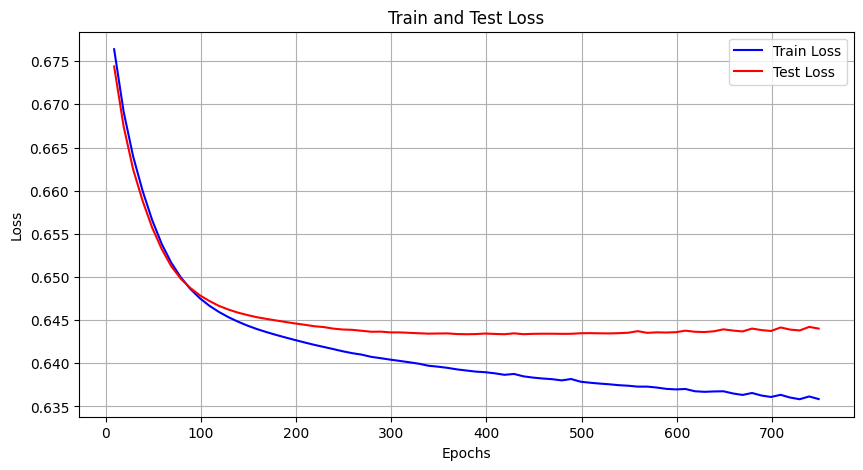

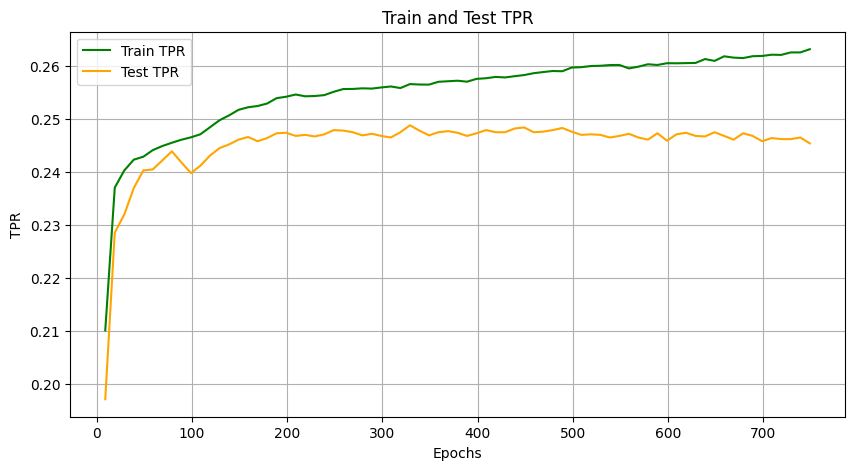

final best loss is 0.6434780955314636 best tpr is 0.2488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:11<00:00, 251.45s/it]

0.24433333333333335 0
[0.24433333333333335]


In [16]:
import warnings
warnings.filterwarnings("ignore")

phases = ["src_train", "train", "dev", "final"]

# hyperparameters
t_value_list = [5, 10, 20, 30, 40, 50, 100]
addt_value_list=[0] # here addt is always 0, which means we are using the basic t loss functions, please refer to our white paper for details
noise_num = 300

Hidden_DIM = 200 # the dimension of the hidden layer
NUM_Epochs = 750 # number of training epochs
DATA_PER_MODEL = 3000 # the number of train data (including DATA_PER_MODEL members and DATA_PER_MODEL hold-out) used in each model in train_indices
TEST_DATA_MODEL = 1000 # the number of validation data used in each model not in train_indices
# less important hyperparameters
USE_BEST_CHECKPOINT=True # use the best checkpoint of the model evaluated at validation MIA TPR @ 0.1FPR
test_model_num = 10
# hyperparameters done

noise_num_sample = noise_num
parallel_batch = noise_num_sample
noise_batch_num = 1
batch_size=200
repeated_times = 1

# generate noises randomly
input_noise_list = [np.random.normal(size=8).tolist() for _ in range(noise_num)]
challenge_name = 'challenge_with_id.csv'
challenge_label_name = 'challenge_label.csv'
test_set_ratio = float(test_model_num/30)

######################################################
## new global var setting
## ----------------------------------------------------------------------------- 
## select several models for training, the rest as validation sets
import random

all_indices = list(range(30))  # 0-29
train_indices = random.sample(all_indices, int(30 - test_model_num))

### data processing (merge)
BASE_PATH = "./tabddpm_black_box/train/tabddpm_"
# train
df_train_merge = pd.concat(
    [pd.read_csv(os.path.join(BASE_PATH + str(t+1), "train_with_id.csv")) for t in train_indices], ignore_index=True
).drop_duplicates(subset=["trans_id", "balance"])

df_train_challenge = pd.concat(
    [pd.read_csv(os.path.join(BASE_PATH + str(t+1), "challenge_with_id.csv")) for t in all_indices], ignore_index=True
).drop_duplicates(subset=["trans_id", "balance"])

df_train_merge = df_train_merge[~df_train_merge.set_index(["trans_id", "balance"]).index.isin
                            (df_train_challenge.set_index(["trans_id", "balance"]).index)]

# test
test_indices = list(set(all_indices) - set(train_indices))
df_test_merge = pd.concat(
    [pd.read_csv(os.path.join(BASE_PATH + str(t+1), "train_with_id.csv")) for t in test_indices], ignore_index=True
).drop_duplicates(subset=["trans_id", "balance"])

df_test_challenge = pd.concat(
    [pd.read_csv(os.path.join(BASE_PATH + str(t+1), "challenge_with_id.csv")) for t in all_indices], ignore_index=True
).drop_duplicates(subset=["trans_id", "balance"])

df_test_merge = df_test_merge[~df_test_merge.set_index(["trans_id", "balance"]).index.isin
                            (df_test_challenge.set_index(["trans_id", "balance"]).index)]
### data processing (merge) done

print("the number of merge train data", len(df_train_merge))
total_data_num = DATA_PER_MODEL * 2 * int(30 - test_model_num)

# create np arrays for train data (+label) and test data (+label)
X_TRAIN = np.zeros([total_data_num, noise_num_sample*len(t_value_list)*len(addt_value_list)])
X_LABEL = np.zeros([total_data_num])  

X_TEST = np.zeros([TEST_DATA_MODEL * 2  * test_model_num, noise_num_sample*len(t_value_list)*len(addt_value_list)])
X_LABEL2 = np.zeros([TEST_DATA_MODEL * 2 * test_model_num]) 
## ----------------------------------------------------------------------------- 

# define the MLP here
regression_model = MLP(input_dim=noise_num_sample*len(t_value_list)*len(addt_value_list), hidden_dim=Hidden_DIM).cuda()
t_value = t_value_list[0]
plot_res = []
# call main_function_process to run the whole pipeline
for noise_batch_id in tqdm(range(noise_batch_num)):
    input_noise = input_noise_list[noise_batch_id * parallel_batch: (noise_batch_id+1) * parallel_batch]
    final_tpr_at_fpr, final_tpr_at_fpr2 = main_function_process()
    plot_res.append(final_tpr_at_fpr)
    print(final_tpr_at_fpr, final_tpr_at_fpr2)

print(plot_res)

## Scoring for MIA in train phase

Let's see how the attack does on `train`, for which we have the ground truth.


In [17]:
tpr_at_fpr_list = []

for base_dir in [TABDDPM_DATA_DIR]:
    predictions = []
    solutions  = []
    root = os.path.join(base_dir, "train")
    for model_folder in sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])):
        path = os.path.join(root, model_folder)
        predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
        solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
    
    predictions = np.concatenate(predictions)
    solutions = np.concatenate(solutions)
    
    tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
    tpr_at_fpr_list.append(tpr_at_fpr)
    
    print(f"{base_dir.split('_')[0]} Train Attack TPR at FPR==10%: {tpr_at_fpr}")

final_tpr_at_fpr = max(tpr_at_fpr_list)
print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr}")

tabddpm Train Attack TPR at FPR==10%: 0.24433333333333335
Final Train Attack TPR at FPR==10%: 0.24433333333333335


for result in test_indices:

In [18]:
tpr_at_fpr_list = []
index = 0
for base_dir in [TABDDPM_DATA_DIR]:
    predictions = []
    solutions  = []
    root = os.path.join(base_dir, "train")
    model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
        if index not in test_indices:
            index+=1
            continue
        path = os.path.join(root, model_folder)
        predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
        solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
        index+=1
    
    predictions = np.concatenate(predictions)
    solutions = np.concatenate(solutions)
    
    tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
    tpr_at_fpr_list.append(tpr_at_fpr)
    
    print(f"{base_dir.split('_')[0]} Train Attack TPR at FPR==10%: {tpr_at_fpr}")

final_tpr_at_fpr = max(tpr_at_fpr_list)
print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr}")

tabddpm Train Attack TPR at FPR==10%: 0.241
Final Train Attack TPR at FPR==10%: 0.241


for result in train_indices:

In [19]:
tpr_at_fpr_list = []
index = 0
for base_dir in [TABDDPM_DATA_DIR]:
    predictions = []
    solutions  = []
    root = os.path.join(base_dir, "train")
    model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
        if index not in train_indices:
            index+=1
            continue
        path = os.path.join(root, model_folder)
        predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
        solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
        index+=1
    
    predictions = np.concatenate(predictions)
    solutions = np.concatenate(solutions)
    
    tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
    tpr_at_fpr_list.append(tpr_at_fpr)
    
    print(f"{base_dir.split('_')[0]} Train Attack TPR at FPR==10%: {tpr_at_fpr}")

final_tpr_at_fpr = max(tpr_at_fpr_list)
print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr}")

tabddpm Train Attack TPR at FPR==10%: 0.2525
Final Train Attack TPR at FPR==10%: 0.2525


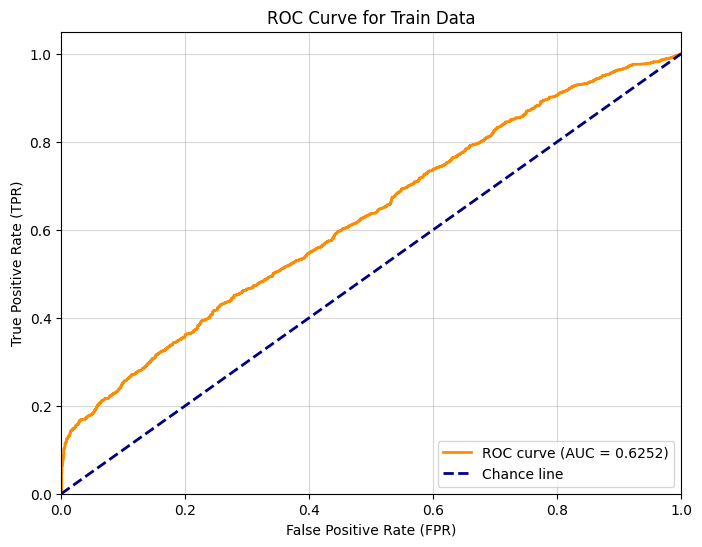

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(solutions, predictions)
roc_auc = auc(fpr, tpr)  

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaBench. Importantly, we create a single zip file for dev and final. The structure of the submission is as follows:

```
└── root_folder
    ├── tabsyn_white_box
    │   ├── dev
    │   │   └── tabsyn_#
    │   │       └── prediction.csv
    │   └── final
    │       └── tabsyn_#
    │           └── prediction.csv
    └── tabddpm_white_box
        ├── dev 
        │   └── tabddpm_#
        │       └── prediction.csv
        └── final 
            └── tabddpm_# 
                └── prediction.csv
```
**Note:** The `root_folder` can have any name but it is important all of the subdirectories follow the above structure and naming conventions. 

If a participant is looking to submit an attack for only one of TabSyn and TabDDPM, they can simply omit the other directory (ie `tabddpm_white_box` or `tabsyn_white_box` from the root_folder).

In [30]:
with zipfile.ZipFile(f"black_box_single_table_submission.zip", 'w') as zipf:
    for phase in ["dev", "final"]:
        for base_dir in [TABDDPM_DATA_DIR]:
            root = os.path.join(base_dir, phase)
            model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
            for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
                path = os.path.join(root, model_folder)
                if not os.path.isdir(path): continue

                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    # Use `arcname` to remove the base directory and phase directory from the zip path
                    arcname = os.path.relpath(file, os.path.dirname(base_dir))
                    zipf.write(file, arcname=arcname)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}.")

The generated white_box_single_table_submission.zip can be directly submitted to the dev phase in the CodaBench UI. Although this submission contains your predictions for both the dev and final set, you will only receive feedback on your predictions for the dev phase. The predictions for the final phase will be evaluated once the competiton ends using the most recent submission to the dev phase.